## Authors

- Bhuvanesh Kumar (1844341)
- Vinayak Sharma (2023BCS0002)


# Quantum Currency Arbitrage using QAOA (Qiskit)

This notebook formulates a **currency arbitrage detection** task as a **Quadratic Unconstrained Binary Optimization (QUBO)** problem and applies the **Quantum Approximate Optimization Algorithm (QAOA)** using **Qiskit**.

## What this notebook covers

- Exchange-rate data ingestion and directed graph construction
- QUBO construction (objective + cycle constraints via penalty terms)
- QUBO → Ising Hamiltonian transformation for QAOA
- Sampling and decoding QAOA bitstrings into selected trades
- Validation and classical baselines (cycle checks, Bellman–Ford negative-cycle detection)
- Profit and fee-sensitivity analysis

## Environment

- Python 3.10
- `qiskit`, `qiskit-aer`, `qiskit-optimization`, `qiskit-algorithms`, `networkx`, `pandas`, `matplotlib`


## Introduction

**Currency arbitrage** exists when a sequence of currency conversions returns more than the starting amount (i.e., the product of rates along a directed cycle exceeds 1).

In this notebook, we:

- Model currencies and exchange rates as a **directed, weighted graph**
- Encode cycle selection as binary decision variables on edges
- Formulate a **QUBO** objective based on `-log(rate)` (turning multiplicative gain into additive cost)
- Use **QAOA** to sample candidate edge selections

### Practical note

Real-world arbitrage profitability depends on spreads, fees, slippage, and execution latency. Later sections include a simple **per-trade fee sensitivity** calculation to illustrate this effect.


## Workflow overview

![Workflow Diagram](https://i.ibb.co/N27zvzS2/Screenshot-2025-11-07-110838.png)

This notebook follows a consistent pipeline:

1. **Formulate the optimization problem (QUBO)**
   - Binary variable per directed trade (edge)
   - Objective based on `-log(rate)`
   - Penalty terms enforce cycle feasibility (one-in / one-out)

2. **Map QUBO to a quantum operator**
   - Convert the QUBO into an **Ising Hamiltonian** usable by QAOA

3. **Execute QAOA-style sampling (simulation)**
   - Build a QAOA ansatz circuit
   - Sample measurement bitstrings on a simulator backend

4. **Post-process and validate**
   - Decode bitstrings → selected edges
   - Check cycle feasibility
   - Compare against classical baselines and compute profitability


## Model setup (Graph → QUBO)

### Decision variables

- Currencies are modeled as nodes in a directed graph.
- Each exchange rate is a directed edge.
- A binary decision variable is assigned to each edge:
  - `x_e = 1` means the trade (edge) is selected
  - `x_e = 0` means the trade is not selected

### Objective

The goal is to find a **profitable cycle**. Since profit along a cycle multiplies rates, we take logs to convert multiplication to addition.

- Maximizing product of rates
- Equivalent to minimizing the sum of negative log-rates:
  - `min Σ (-log(r_e)) x_e`

### Feasibility constraints (cycle constraints)

A valid arbitrage cycle requires:

- Exactly **one outgoing** selected edge per currency
- Exactly **one incoming** selected edge per currency

These constraints are incorporated into the QUBO using **quadratic penalty terms**.


## Problem representation and qubit mapping

### Graph encoding

- Nodes represent currencies (e.g., USD, EUR, GBP).
- Directed edges represent available conversions with an associated exchange rate.

### Variable / qubit assignment

- Each directed edge `(i → j)` is mapped to a unique binary variable `x_k`.
- In the quantum formulation, each `x_k` corresponds to a qubit measured in the computational basis.

### Coefficients

- Linear coefficient for each edge is set to `-log(rate)`.
- Penalty terms add both linear and quadratic coefficients to enforce one-in/one-out constraints.


## Mathematical formulation

Let:

- `r_{ij}` be the exchange rate from currency `i` to currency `j`
- `b_{ij} ∈ {0,1}` indicate whether edge `(i, j)` is selected

### Objective (log form)

Maximize the product of rates along a cycle. Using logs, this becomes a minimization:

$$
C(b) = \sum_{(i,j)} -\log(r_{ij})\, b_{ij}
$$

### Cycle constraints (one-in / one-out)

For each currency `i`:

- One outgoing edge: `\sum_{j \neq i} b_{ij} = 1`
- One incoming edge: `\sum_{j \neq i} b_{ji} = 1`

We enforce these using a quadratic penalty:

$$
P(b) = \sum_i \Big(\sum_{j \neq i} b_{ij} - 1\Big)^2 + \sum_i \Big(\sum_{j \neq i} b_{ji} - 1\Big)^2
$$

### Total QUBO cost

$$
C_{\text{total}}(b) = C(b) + \lambda\,P(b)
$$

where `\lambda` is a penalty strength.

### QUBO → Ising

Binary variables can be mapped to spin variables for quantum operators using:

$$
b = \frac{1 - Z}{2}
$$


# 1. Environment setup

This section installs the required Python packages. If you already have a working environment, you can skip the installation cells.

Note: `%pip` commands are intended for notebook environments (Jupyter/Colab).

In [24]:
%pip uninstall qiskit qiskit-aer qiskit-optimization qiskit-algorithms

^C
Note: you may need to restart the kernel to use updated packages.


## 1.1 Python version

This notebook was executed with **Python 3.10.0**. Some Qiskit components and dependency combinations may behave differently on Python 3.11+.


In [1]:

%pip install --upgrade pip setuptools wheel
%pip install qiskit qiskit-aer qiskit-optimization matplotlib networkx pandas
%pip install qiskit-algorithms


Note: you may need to restart the kernel to use updated packages.




# 2. Problem representation (data and QUBO construction)

In this section we:

- Load exchange-rate data (CSV with fallback sample)
- Build a directed graph of currency conversions
- Define a QUBO with objective and penalty terms


## 2.1 Imports

Import numerical, graph, plotting, and Qiskit Optimization/QAOA utilities used throughout the notebook.

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import math
import os
import sys
import time
from collections import Counter
from pathlib import Path
import pandas as pd
from qiskit_aer import Aer
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA
from qiskit_optimization.converters import QuadraticProgramToQubo



## 2.2 Load exchange-rate data

Load exchange-rate data from `Data/Data-sheet.csv`. If the file is not found, the notebook falls back to a small hard-coded sample dataset.

The code also validates:

- Required columns: `Source`, `Target`, `Rate`
- No missing values
- `Rate` is numeric


In [3]:
def find_data_file(filename="Data-sheet.csv", folder_name="Data", max_up=5):
    p = Path.cwd()
    for _ in range(max_up + 1):
        candidate = p / folder_name / filename
        if candidate.exists():
            return candidate
        p = p.parent
    return None

csv_path = find_data_file()
if csv_path:
    df = pd.read_csv(csv_path,skiprows=0)
    print("Loaded data from:", csv_path)
else:
    print("Data file not found by upward search from", Path.cwd())
    print("Try launching Jupyter from the project root or set csv_path manually.")
    # fallback sample
    data = {
        "Source": ["USD", "USD", "USD", "EUR", "EUR", "GBP", "CAD", "JPY", "AUD", "CHF"],
        "Target": ["EUR", "GBP", "CAD", "USD", "GBP", "CAD", "EUR", "USD", "USD", "USD"],
        "Rate":   [0.89, 0.84, 1.39, 0.89, 0.75, 0.54, 0.82, 0.0069, 0.64, 1.07]
    }
    df = pd.DataFrame(data)

# validation
required_columns = ["Source", "Target", "Rate"]
if not all(col in df.columns for col in required_columns):
    raise ValueError("Missing required columns in dataset")
if df[required_columns].isnull().any().any():
    raise ValueError("Dataset contains missing values")
if not pd.api.types.is_numeric_dtype(df["Rate"]):
    raise ValueError("'Rate' column must be numeric")

print(df.to_string())



Loaded data from: d:\Windsurf\qiskit-final-check\Currency-Arbitrage-using-Quantum-Methodology-qiskit\Data\Data-sheet.csv
   Source Target      Rate
0     USD    EUR    1.1200
1     USD    GBP    0.8400
2     USD    CAD    1.3900
3     EUR    USD    0.8900
4     EUR    GBP    0.7500
5     EUR    CAD    1.2200
6     GBP    USD    1.1800
7     GBP    EUR    1.3300
8     GBP    CAD    1.8600
9     CAD    USD    0.7200
10    CAD    EUR    0.8200
11    CAD    GBP    0.5400
12    JPY    USD    0.0069
13    USD    JPY  144.8000
14    AUD    USD    0.6400
15    USD    AUD    1.5500
16    CHF    USD    1.0700
17    USD    CHF    0.9300


## 2.3 Map edges to binary variables (qubits)

Each directed edge is assigned a unique binary variable `x0, x1, ..., x_{m-1}` where `m` is the number of edges.

This mapping is later used to interpret measured bitstrings (which edges were selected).

In [4]:
# Ensure 'df' is present and Rate is numeric
if 'df' not in globals():
    raise RuntimeError("DataFrame 'df' not found. Run the data-loading cell first.")

# Force Rate to numeric (will raise if non-numeric values exist)
df["Rate"] = pd.to_numeric(df["Rate"], errors="raise")

# Option A — preserve CSV row order
edges = list(zip(df["Source"].tolist(), df["Target"].tolist(), df["Rate"].tolist()))

# Build mapping (index, variable name, human-readable edge, rate)
mapping = []
for i, (src, dst, rate) in enumerate(edges):
    mapping.append((i, f"x{i}", f"{src} → {dst}", rate))

# Display as DataFrame
mapping_df = pd.DataFrame(mapping, columns=["Qubit", "Variable", "Edge", "Rate"])
print(f"Total edges: {len(mapping_df)}")
print(mapping_df.to_string(index=False))


Total edges: 18
 Qubit Variable      Edge     Rate
     0       x0 USD → EUR   1.1200
     1       x1 USD → GBP   0.8400
     2       x2 USD → CAD   1.3900
     3       x3 EUR → USD   0.8900
     4       x4 EUR → GBP   0.7500
     5       x5 EUR → CAD   1.2200
     6       x6 GBP → USD   1.1800
     7       x7 GBP → EUR   1.3300
     8       x8 GBP → CAD   1.8600
     9       x9 CAD → USD   0.7200
    10      x10 CAD → EUR   0.8200
    11      x11 CAD → GBP   0.5400
    12      x12 JPY → USD   0.0069
    13      x13 USD → JPY 144.8000
    14      x14 AUD → USD   0.6400
    15      x15 USD → AUD   1.5500
    16      x16 CHF → USD   1.0700
    17      x17 USD → CHF   0.9300


## 2.4 Build a directed exchange graph

Construct a `networkx.DiGraph` where:

- Nodes are currencies
- Directed edges represent conversions
- Edge weights store exchange rates

We also create:

- A canonical `currencies` list
- An `edges` list to define decision-variable ordering


In [5]:
G = nx.DiGraph()
for _, row in df.iterrows():
    G.add_edge(row["Source"], row["Target"], weight=row["Rate"])

currencies = list(G.nodes)
edges = list(G.edges())
num_currencies = len(currencies)
num_variables = len(edges)

print(f"Currencies: {currencies}")
print(f"Number of decision variables (edges): {num_variables}")
for i, (src, dst) in enumerate(edges):
    print(f"  Qubit {i}: b_{{{src}->{dst}}}")

Currencies: ['USD', 'EUR', 'GBP', 'CAD', 'JPY', 'AUD', 'CHF']
Number of decision variables (edges): 18
  Qubit 0: b_{USD->EUR}
  Qubit 1: b_{USD->GBP}
  Qubit 2: b_{USD->CAD}
  Qubit 3: b_{USD->JPY}
  Qubit 4: b_{USD->AUD}
  Qubit 5: b_{USD->CHF}
  Qubit 6: b_{EUR->USD}
  Qubit 7: b_{EUR->GBP}
  Qubit 8: b_{EUR->CAD}
  Qubit 9: b_{GBP->USD}
  Qubit 10: b_{GBP->EUR}
  Qubit 11: b_{GBP->CAD}
  Qubit 12: b_{CAD->USD}
  Qubit 13: b_{CAD->EUR}
  Qubit 14: b_{CAD->GBP}
  Qubit 15: b_{JPY->USD}
  Qubit 16: b_{AUD->USD}
  Qubit 17: b_{CHF->USD}


## 2.5 Visualize the exchange graph

Plot the directed graph with exchange rates as edge labels to verify the dataset structure visually.

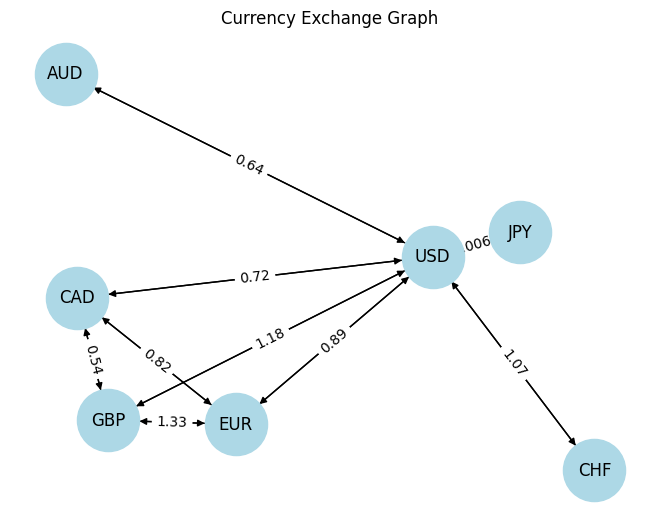

In [6]:
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Currency Exchange Graph")
plt.show()

## 2.6 Define QUBO coefficients

We build the QUBO coefficients:

- **Linear terms**: `-log(rate)` for each edge (objective)
- **Penalty terms**: encourage exactly one incoming and one outgoing edge per currency

The penalty strength controls how strongly invalid selections are discouraged.

In [7]:
penalty_factor = 5.0
linear = {}
quadratic = {}

for i, (src, dst) in enumerate(edges):
    rate = G[src][dst]["weight"]
    linear[f"x{i}"] = -math.log(rate)

for i in range(num_variables):
    linear[f"x{i}"] -= 4 * penalty_factor

for src in currencies:
    out_vars = [f"x{j}" for j, (u, v) in enumerate(edges) if u == src]
    for a in range(len(out_vars)):
        for b in range(a + 1, len(out_vars)):
            quadratic[(out_vars[a], out_vars[b])] = penalty_factor

for dst in currencies:
    in_vars = [f"x{j}" for j, (u, v) in enumerate(edges) if v == dst]
    for a in range(len(in_vars)):
        for b in range(a + 1, len(in_vars)):
            quadratic[(in_vars[a], in_vars[b])] = penalty_factor

constant = 2 * num_currencies * penalty_factor
print(f"Penalty factor: {penalty_factor}, Constant term: {constant}")
print(f"Number of quadratic terms: {len(quadratic)}")

Penalty factor: 5.0, Constant term: 70.0
Number of quadratic terms: 48


## 2.7 Create the QUBO model

Create a `QuadraticProgram`, define binary decision variables, and attach the linear/quadratic objective coefficients.

This produces a QUBO suitable for conversion to an Ising Hamiltonian for QAOA.

In [8]:
qp = QuadraticProgram()
for i in range(num_variables):
    qp.binary_var(name=f"x{i}")
qp.minimize(linear=linear, quadratic=quadratic)
print(qp.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: - 20.113328685307 x0 - 19.825646612855 x1 - 20.329303747143 x2
      - 24.975353479952 x3 - 20.438254930931 x4 - 19.927429307165 x5
      - 19.883466183744 x6 - 19.712317927548 x7 - 20.198850858745 x8
      - 20.165514438478 x9 - 20.285178942234 x10 - 20.620576487725 x11
      - 19.671495933028 x12 - 19.801549061276 x13 - 19.383813860576 x14
      - 15.023766132621 x15 - 19.553712897372 x16 - 20.067658648474 x17 + [
      10 x0*x1 + 10 x0*x2 + 10 x0*x3 + 10 x0*x4 + 10 x0*x5 + 10 x0*x10
      + 10 x0*x13 + 10 x1*x2 + 10 x1*x3 + 10 x1*x4 + 10 x1*x5 + 10 x1*x7
      + 10 x1*x14 + 10 x2*x3 + 10 x2*x4 + 10 x2*x5 + 10 x2*x8 + 10 x2*x11
      + 10 x3*x4 + 10 x3*x5 + 10 x4*x5 + 10 x6*x7 + 10 x6*x8 + 10 x6*x9
      + 10 x6*x12 + 10 x6*x15 + 10 x6*x16 + 10 x6*x17 + 10 x7*x8 + 10 x7*x14
      + 10 x8*x11 + 10 x9*x10 + 10 x9*x11 + 10 x9*x12 + 10 x9*x15 + 10 x9*x16
      + 10 x9*x17 + 10 x10*x11 + 1

C:\Users\Admin\AppData\Local\Temp\ipykernel_10960\3528552412.py:5: DeprecationWarning: The method ``qiskit_optimization.problems.quadratic_program.QuadraticProgram.export_as_lp_string()`` is deprecated as of Qiskit 0.7.0. It will be removed no earlier than 3 months after the release date. Use prettyprint instead.
  print(qp.export_as_lp_string())


# 3. QAOA formulation and execution

This section converts the QUBO into an **Ising Hamiltonian** and constructs a **QAOA ansatz circuit**.

At a high level, QAOA alternates between:

- **Problem unitary** derived from the Ising Hamiltonian (parameterized by `γ`)
- **Mixer unitary** (typically X-rotations, parameterized by `β`)

Measured bitstrings correspond to candidate edge selections, which we later validate and analyze.


## 3.1 Convert QUBO to an Ising Hamiltonian

Use Qiskit Optimization utilities to convert the QUBO into an Ising operator (`SparsePauliOp`) plus an energy offset.

This operator is the input to QAOA.

In [9]:
qubo_converter = QuadraticProgramToQubo()
qubo = qubo_converter.convert(qp)
ising_op, offset = qubo.to_ising()
print("Ising Hamiltonian:")
print(ising_op)
print(f"Ising constant offset: {offset:.4f}")

Ising Hamiltonian:
SparsePauliOp(['IIIIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIIIZII', 'IIIIIIIIIIIIIIZIII', 'IIIIIIIIIIIIIZIIII', 'IIIIIIIIIIIIZIIIII', 'IIIIIIIIIIIZIIIIII', 'IIIIIIIIIIZIIIIIII', 'IIIIIIIIIZIIIIIIII', 'IIIIIIIIZIIIIIIIII', 'IIIIIIIZIIIIIIIIII', 'IIIIIIZIIIIIIIIIII', 'IIIIIZIIIIIIIIIIII', 'IIIIZIIIIIIIIIIIII', 'IIIZIIIIIIIIIIIIII', 'IIZIIIIIIIIIIIIIII', 'IZIIIIIIIIIIIIIIII', 'ZIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIIIZIZ', 'IIIIIIIIIIIIIIZIIZ', 'IIIIIIIIIIIIIZIIIZ', 'IIIIIIIIIIIIZIIIIZ', 'IIIIIIIZIIIIIIIIIZ', 'IIIIZIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIZZI', 'IIIIIIIIIIIIIIZIZI', 'IIIIIIIIIIIIIZIIZI', 'IIIIIIIIIIIIZIIIZI', 'IIIIIIIIIIZIIIIIZI', 'IIIZIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIIZZII', 'IIIIIIIIIIIIIZIZII', 'IIIIIIIIIIIIZIIZII', 'IIIIIIIIIZIIIIIZII', 'IIIIIIZIIIIIIIIZII', 'IIIIIIIIIIIIIZZIII', 'IIIIIIIIIIIIZIZIII', 'IIIIIIIIIIIIZZIIII', 'IIIIIIIIIIZZIIIIII', 'IIIIIIIIIZIZIIIIII', 'IIIIIIIIZIIZIIIIII', 'IIIIIZIIIIIZIIIIII', 'IIZIIIIIIIIZIIIIII'

## 3.2 Sample a QAOA ansatz circuit

Here we:

- Build a `QAOAAnsatz` circuit for the Ising operator
- Add measurements on all qubits
- Bind a set of parameter values (example initialization)
- Use a simulator sampler to draw bitstring samples

The output is a probability distribution over measured bitstrings.

In [10]:

from qiskit.circuit.library import QAOAAnsatz
from qiskit_aer.primitives import Sampler
import numpy as np

# 1) Build/decompose the ansatz (reps already chosen earlier)
reps = 2
ansatz = QAOAAnsatz(ising_op, reps=reps)
decomposed = ansatz.decompose()   

# 2) Add measurements (measure all qubits)
qc = decomposed.copy()
qc.measure_all()                  # adds classical bits and measure ops

# 3) Choose parameter values to evaluate (example: small random or zeros)
#    ansatz.parameters is an ordered list of Parameter objects (gamma/beta)
param_list = list(ansatz.parameters)
# Example initial values: zeros or small randoms
init_vals = np.zeros(len(param_list))   # or np.random.uniform(0, 0.1, size=len(param_list))

# 4) Run the sampler on the measured, bound circuit
sampler = Sampler()
# sampler.run expects a sequence of circuits and a matching list of parameter tuples
job = sampler.run([qc], parameter_values=[tuple(init_vals)], shots=1024)
raw = job.result()

# 5) Extract the probability distribution (quasi distribution)
# raw.quasi_dists is a list (one entry per circuit) mapping int->probability
quasi = raw.quasi_dists[0]   # dict: {int_bitstring: probability}
print("Number of distinct bitstrings sampled:", len(quasi))

# 6) Convert integer keys to bitstrings of length num_variables
def int_to_bitstr(x, n):
    return format(x, f"0{n}b")

probs = {int_to_bitstr(k, num_variables): v for k, v in quasi.items()}

# 7) Compute expected QUBO energy from the distribution
def qubo_energy_from_bitstr(bitstr, linear_coeffs, quadratic_terms, constant):
    x = [int(b) for b in bitstr]
    energy = constant
    for i in range(len(x)):
        energy += linear_coeffs[f"x{i}"] * x[i]
    for (a, b), coeff in quadratic_terms.items():
        i = int(a[1:]); j = int(b[1:])
        energy += coeff * x[i] * x[j]
    return energy

expected_energy = 0.0
for bstr, p in probs.items():
    expected_energy += p * qubo_energy_from_bitstr(bstr, linear, quadratic, constant)

# 8) Pick the most probable bitstring
best_bstr = max(probs.items(), key=lambda kv: kv[1])[0]
result = type("Obj", (), {"x": [int(ch) for ch in best_bstr]})()

print("Most probable bitstring:", best_bstr)
print("Expected QUBO energy (over samples):", expected_energy)
print("Selected edges:", [edges[i] for i, bit in enumerate(result.x) if bit == 1])


Number of distinct bitstrings sampled: 1022
Most probable bitstring: 000010011001111001
Expected QUBO energy (over samples): -50.42540587474125
Selected edges: [('USD', 'AUD'), ('EUR', 'GBP'), ('EUR', 'CAD'), ('GBP', 'CAD'), ('CAD', 'USD'), ('CAD', 'EUR'), ('CAD', 'GBP'), ('CHF', 'USD')]


## 3.3 Inspect the QAOA circuit structure

Print and inspect the decomposed circuit to understand circuit depth and gate count (useful for assessing scalability and runtime on simulators/hardware).

In [11]:
decomposed = ansatz.decompose()
print(decomposed)
print("Circuit depth:", decomposed.depth())
print("Total gates:", decomposed.size())


      ┌───┐»
 q_0: ┤ H ├»
      ├───┤»
 q_1: ┤ H ├»
      ├───┤»
 q_2: ┤ H ├»
      ├───┤»
 q_3: ┤ H ├»
      ├───┤»
 q_4: ┤ H ├»
      ├───┤»
 q_5: ┤ H ├»
      ├───┤»
 q_6: ┤ H ├»
      ├───┤»
 q_7: ┤ H ├»
      ├───┤»
 q_8: ┤ H ├»
      ├───┤»
 q_9: ┤ H ├»
      ├───┤»
q_10: ┤ H ├»
      ├───┤»
q_11: ┤ H ├»
      ├───┤»
q_12: ┤ H ├»
      ├───┤»
q_13: ┤ H ├»
      ├───┤»
q_14: ┤ H ├»
      ├───┤»
q_15: ┤ H ├»
      ├───┤»
q_16: ┤ H ├»
      ├───┤»
q_17: ┤ H ├»
      └───┘»
«      ┌───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

## 3.4 Construct and display the QAOA ansatz

Create a QAOA ansatz circuit with a chosen number of layers (`reps`) and display the symbolic circuit. This is a helpful sanity check before running repeated experiments.

In [12]:
from qiskit.circuit.library import QAOAAnsatz
from qiskit_algorithms.optimizers import COBYLA

# reps = number of QAOA layers
reps = 2

# Build the QAOA ansatz circuit from the Ising operator
qaoa_ansatz = QAOAAnsatz(ising_op, reps=reps)

print("QAOA Circuit (symbolic parameters):")
print(qaoa_ansatz)

print(f"\nCircuit depth: {qaoa_ansatz.depth()}")
print(f"Total gates: {qaoa_ansatz.size()}")

QAOA Circuit (symbolic parameters):
      ┌─────────────────────────────┐
 q_0: ┤0                            ├
      │                             │
 q_1: ┤1                            ├
      │                             │
 q_2: ┤2                            ├
      │                             │
 q_3: ┤3                            ├
      │                             │
 q_4: ┤4                            ├
      │                             │
 q_5: ┤5                            ├
      │                             │
 q_6: ┤6                            ├
      │                             │
 q_7: ┤7                            ├
      │                             │
 q_8: ┤8                            ├
      │   QAOA(γ[0],β[0],γ[1],β[1]) │
 q_9: ┤9                            ├
      │                             │
q_10: ┤10                           ├
      │                             │
q_11: ┤11                           ├
      │                             │
q_12: ┤12     

## 3.5 Decode the most probable bitstring

Convert the sampled bitstring into a list of selected edges using the variable/edge mapping from Section 2.

This produces a candidate set of trades that we validate in the next section.

In [13]:
bitstring = "".join(str(int(x)) for x in result.x)
selected_edges = [edges[i] for i, bit in enumerate(result.x) if bit > 0.5]
print(f"Most frequent bitstring: {bitstring}")
print(f"Selected edges: {selected_edges}")

Most frequent bitstring: 000010011001111001
Selected edges: [('USD', 'AUD'), ('EUR', 'GBP'), ('EUR', 'CAD'), ('GBP', 'CAD'), ('CAD', 'USD'), ('CAD', 'EUR'), ('CAD', 'GBP'), ('CHF', 'USD')]


# 4. Validation and baseline checks

QAOA sampling can return bitstrings that do **not** correspond to a valid cycle (e.g., a currency may have multiple outgoing edges selected). This section validates feasibility and compares against simple classical baselines.


## 4.1 Validate cycle constraints for the selected edges

We compute incoming/outgoing counts per currency for the edges selected by the sampled bitstring.

- A valid directed cycle requires **exactly one outgoing** and **exactly one incoming** edge for every currency involved.

If the counts violate this, the QAOA sample is infeasible under the cycle constraints.

In [14]:
# diagnostic: show counts per currency
incoming = {c: 0 for c in currencies}
outgoing = {c: 0 for c in currencies}
for u, v in selected_edges:
    outgoing[u] += 1
    incoming[v] += 1

print("Selected edges:", selected_edges)
print("Outgoing counts:", outgoing)
print("Incoming counts:", incoming)

bad = {c: (incoming[c], outgoing[c]) for c in currencies if incoming[c] != 1 or outgoing[c] != 1}
print("Currencies violating cycle constraint:", bad)


Selected edges: [('USD', 'AUD'), ('EUR', 'GBP'), ('EUR', 'CAD'), ('GBP', 'CAD'), ('CAD', 'USD'), ('CAD', 'EUR'), ('CAD', 'GBP'), ('CHF', 'USD')]
Outgoing counts: {'USD': 1, 'EUR': 2, 'GBP': 1, 'CAD': 3, 'JPY': 0, 'AUD': 0, 'CHF': 1}
Incoming counts: {'USD': 2, 'EUR': 1, 'GBP': 2, 'CAD': 2, 'JPY': 0, 'AUD': 1, 'CHF': 0}
Currencies violating cycle constraint: {'USD': (2, 1), 'EUR': (1, 2), 'GBP': (2, 1), 'CAD': (2, 3), 'JPY': (0, 0), 'AUD': (1, 0), 'CHF': (0, 1)}


## 4.2 Classical feasibility baseline (brute force)

As a sanity check, we perform a brute-force search over all bitstrings (for small problem sizes) to see whether any feasible cycle exists under the current encoding and to identify the best feasible energy.

This is used strictly as a baseline/diagnostic and is not scalable for large instances.

In [15]:
# Brute-force baseline: find feasible cycles and best energy
from itertools import product

def qubo_energy_tuple(x_tuple, linear_coeffs, quadratic_terms, constant):
    energy = constant
    for i in range(len(x_tuple)):
        energy += linear_coeffs[f"x{i}"] * x_tuple[i]
    for (a, b), coeff in quadratic_terms.items():
        i = int(a[1:]); j = int(b[1:])
        energy += coeff * x_tuple[i] * x_tuple[j]
    return energy

def is_valid_cycle_edges_from_bits(bits, edges, currencies):
    selected = [edges[i] for i, b in enumerate(bits) if b==1]
    if len(selected) != len(currencies):
        return False, selected
    incoming = {c:0 for c in currencies}
    outgoing = {c:0 for c in currencies}
    for u,v in selected:
        outgoing[u]+=1; incoming[v]+=1
    for c in currencies:
        if incoming[c]!=1 or outgoing[c]!=1:
            return False, selected
    return True, selected

best = None
best_energy = float("inf")
feasible_solutions = []

for bits in product([0,1], repeat=num_variables):
    ok, sel = is_valid_cycle_edges_from_bits(bits, edges, currencies)
    if ok:
        e = qubo_energy_tuple(bits, linear, quadratic, constant)
        feasible_solutions.append((bits, e, sel))
        if e < best_energy:
            best_energy = e
            best = (bits, e, sel)

print("Feasible solutions found:", len(feasible_solutions))
if best:
    bits, e, sel = best
    bitstr = "".join(str(b) for b in bits)
    print("Best feasible bitstring:", bitstr)
    print("Energy:", e)
    print("Edges:", sel)
else:
    print("No feasible cycle found with current QUBO encoding.")


Feasible solutions found: 0
No feasible cycle found with current QUBO encoding.


## 4.3 Strengthen constraints and rebuild the QUBO

If feasibility is not achieved, we can increase the penalty strength used in the `(sum - 1)^2` terms.

This typically improves feasibility but may also make optimization harder due to a larger energy scale separation between feasible and infeasible states.

In [16]:
# Strong (sum-1)^2 penalty encoding for in/out constraints
penalty = 50.0   # increase if infeasible persists
linear = {f"x{i}": 0.0 for i in range(num_variables)}
quadratic = {}
constant = 0.0

# objective linear part from -log(rate)
for i, (src, dst) in enumerate(edges):
    rate = G[src][dst]["weight"]
    linear[f"x{i}"] += -math.log(rate)

# For each currency, enforce (sum_out - 1)^2 and (sum_in - 1)^2
for src in currencies:
    out_vars = [f"x{j}" for j, (u, v) in enumerate(edges) if u == src]
    for vname in out_vars:
        linear[vname] += -penalty
    for a in range(len(out_vars)):
        for b in range(a+1, len(out_vars)):
            pair = (out_vars[a], out_vars[b])
            quadratic[pair] = quadratic.get(pair, 0.0) + 2.0 * penalty
    constant += penalty

for dst in currencies:
    in_vars = [f"x{j}" for j, (u, v) in enumerate(edges) if v == dst]
    for vname in in_vars:
        linear[vname] += -penalty
    for a in range(len(in_vars)):
        for b in range(a+1, len(in_vars)):
            pair = (in_vars[a], in_vars[b])
            quadratic[pair] = quadratic.get(pair, 0.0) + 2.0 * penalty
    constant += penalty

# Recreate QuadraticProgram and convert
qp = QuadraticProgram()
for i in range(num_variables):
    qp.binary_var(name=f"x{i}")
qp.minimize(linear=linear, quadratic=quadratic)
qubo_converter = QuadraticProgramToQubo()
qubo = qubo_converter.convert(qp)
ising_op, offset = qubo.to_ising()
print("Rebuilt QUBO and Ising operator with penalty =", penalty)


Rebuilt QUBO and Ising operator with penalty = 50.0


## 4.4 Post-processing sampled bitstrings

Even when the most probable bitstring is infeasible, feasible solutions may appear among other high-probability samples.

Here we scan the top samples (by probability) and return the first bitstring that satisfies the cycle constraints.

In [17]:
# Given `probs` dict mapping bitstring->probability (from sampler)
sorted_bstrs = sorted(probs.items(), key=lambda kv: kv[1], reverse=True)
feasible = None
for bstr, p in sorted_bstrs[:200]:   # check top 200 samples
    bits = tuple(int(ch) for ch in bstr)
    ok, sel = is_valid_cycle_edges_from_bits(bits, edges, currencies)
    if ok:
        feasible = (bstr, p, sel)
        break

if feasible:
    print("Found feasible sample among top samples:", feasible)
else:
    print("No feasible sample found among top samples.")


No feasible sample found among top samples.


# 5. Results and interpretation

This section focuses on interpreting outcomes:

- Graph-theoretic feasibility checks (existence of cycles)
- A classical arbitrage detection baseline (Bellman–Ford on `-log(rate)`)
- Profit computation for a selected cycle, including fee sensitivity
- Energy comparisons and visualization


## 5.1 Directed Hamiltonian-cycle feasibility check

A Hamiltonian cycle visits every currency exactly once. In practice, arbitrage opportunities may involve a subset of currencies; however, this check helps determine whether the *full* directed graph supports a complete one-visit-per-currency cycle under the available edges.

This is a diagnostic step and not required for arbitrage detection in general.

In [18]:
from itertools import permutations

def find_hamiltonian_cycle(currencies, edges):
    edge_set = set(edges)  # edges are tuples (u,v)
    n = len(currencies)
    for perm in permutations(currencies):
        ok = True
        for i in range(n):
            u = perm[i]
            v = perm[(i+1) % n]
            if (u, v) not in edge_set:
                ok = False
                break
        if ok:
            return list(zip(perm, perm[1:]+perm[:1]))  # list of edges in cycle
    return None

ham_cycle = find_hamiltonian_cycle(currencies, edges)
if ham_cycle:
    print("Found Hamiltonian cycle (edges):", ham_cycle)
else:
    print("No Hamiltonian cycle exists in the directed graph.")


No Hamiltonian cycle exists in the directed graph.


## 5.2 Classical arbitrage baseline (Bellman–Ford negative-cycle detection)

A standard classical approach to detect arbitrage is to transform rates using `w_{ij} = -log(r_{ij})`.

- A **negative cycle** in this transformed graph corresponds to an arbitrage opportunity (product of rates > 1 in the original graph).

This baseline helps validate that the dataset contains arbitrage opportunities independent of QAOA sampling.

In [19]:
import math

# Build graph with weights = -log(rate)
G_w = nx.DiGraph()
for u, v, r in df[["Source","Target","Rate"]].itertuples(index=False, name=None):
    G_w.add_edge(u, v, weight=-math.log(r))

# Bellman-Ford style: detect negative cycle and return it
def find_negative_cycle(G):
    nodes = list(G.nodes)
    dist = {n: 0.0 for n in nodes}
    pred = {n: None for n in nodes}
    # relax |V|-1 times
    for _ in range(len(nodes)-1):
        updated = False
        for u, v, d in G.edges.data('weight'):
            if dist[u] + d < dist[v]:
                dist[v] = dist[u] + d
                pred[v] = u
                updated = True
        if not updated:
            break
    # one more pass to find negative cycle
    for u, v, d in G.edges.data('weight'):
        if dist[u] + d < dist[v]:
            # found negative cycle; backtrack to get cycle nodes
            cycle = []
            cur = v
            for _ in range(len(nodes)):
                cur = pred[cur]
            start = cur
            cycle.append(start)
            cur = pred[start]
            while cur != start:
                cycle.append(cur)
                cur = pred[cur]
            cycle.reverse()
            return cycle
    return None

neg_cycle = find_negative_cycle(G_w)
if neg_cycle:
    # compute product of rates along cycle
    prod = 1.0
    cycle_edges = []
    for i in range(len(neg_cycle)):
        a = neg_cycle[i]
        b = neg_cycle[(i+1) % len(neg_cycle)]
        r = G[a][b]['weight']
        cycle_edges.append((a,b,r))
        prod *= r
    print("Arbitrage cycle found:", neg_cycle)
    print("Edges (u,v,rate):", cycle_edges)
    print("Product of rates:", prod)
else:
    print("No profitable arbitrage cycle (product>1) detected by Bellman-Ford.")


Arbitrage cycle found: ['GBP', 'CAD']
Edges (u,v,rate): [('GBP', 'CAD', 1.86), ('CAD', 'GBP', 0.54)]
Product of rates: 1.0044000000000002


## 5.3 Profit calculation for a chosen cycle

Given a proposed arbitrage cycle, we compute:

- The product of exchange rates along the cycle
- The implied gross profit percentage

We also visualize the detected cycle on the graph for interpretability.

Cycle: ['USD', 'CAD', 'EUR']
Product of rates: 1.014422
Profit percent: 1.4421999999999935


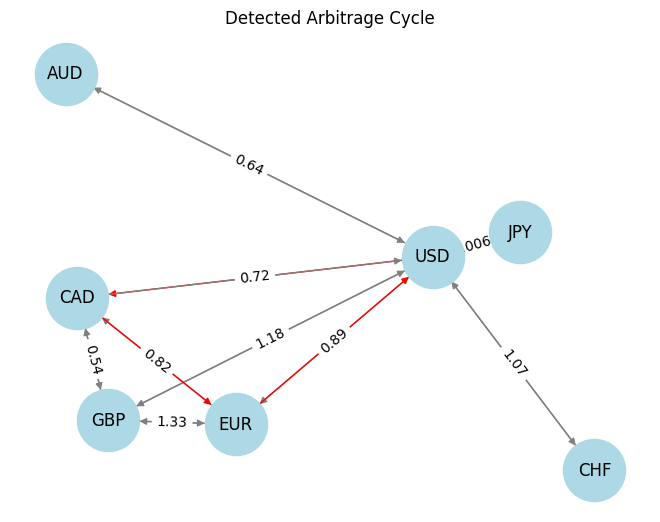

In [20]:
cycle = ['USD','CAD','EUR']
prod = 1.0
for i in range(len(cycle)):
    u = cycle[i]
    v = cycle[(i+1) % len(cycle)]
    r = G[u][v]['weight']
    prod *= r
print("Cycle:", cycle)
print("Product of rates:", prod)
print("Profit percent:", (prod - 1.0) * 100)

# visualize cycle edges in red
cycle_edges = [(cycle[i], cycle[(i+1)%len(cycle)]) for i in range(len(cycle))]
edge_colors = ['red' if e in cycle_edges else 'gray' for e in G.edges()]
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, edge_color=edge_colors)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Detected Arbitrage Cycle")
plt.show()


## 5.4 Enumerate profitable cycles (reference) and compare energies

We enumerate simple directed cycles and list those with product of rates > 1.

This provides a reference set of profitable cycles (when the graph is small enough) and can be used to compare against the QAOA-selected candidate.

In addition, we include a basic energy comparison for diagnostic purposes.

In [21]:
import math
cycles = list(nx.simple_cycles(G))
profitable = []
for cyc in cycles:
    prod = 1.0
    for i in range(len(cyc)):
        u = cyc[i]; v = cyc[(i+1)%len(cyc)]
        prod *= G[u][v]['weight']
    if prod > 1.0:
        profitable.append((cyc, prod))
profitable_sorted = sorted(profitable, key=lambda x: -x[1])
print("Profitable cycles (sorted):")
for cyc, p in profitable_sorted:
    print(cyc, p)


Profitable cycles (sorted):
['GBP', 'CAD', 'EUR'] 1.1439
['GBP', 'CAD', 'EUR', 'USD'] 1.1402395199999997
['GBP', 'CAD', 'USD', 'EUR'] 1.1249280000000002
['GBP', 'CAD', 'USD'] 1.124928
['USD', 'CAD', 'EUR'] 1.014422
['GBP', 'USD', 'CAD', 'EUR'] 1.0087229999999998
['GBP', 'CAD'] 1.0044000000000002
['USD', 'CAD'] 1.0008
['CAD', 'EUR'] 1.0004


## 5.5 Summary and fee sensitivity

### Summary

- **Detected cycle (example)**: USD → CAD → EUR → USD
- **Gross product of rates**: 1.014422 (≈ +1.4422% gross)

### Fee sensitivity

In practice, each trade incurs costs (fees/spread/slippage). If we assume a constant per-trade fee `f` and `k` trades in the cycle, the net return is:

$$
(\prod \text{rates})\,(1-f)^k
$$

The break-even fee `f*` satisfies:

$$
(\prod \text{rates})\,(1-f^*)^k = 1
$$

Solving gives:

$$
1-f^* = \Big(\frac{1}{\prod \text{rates}}\Big)^{1/k}
$$

For `k = 3` and `\prod \text{rates} = 1.014422`, this yields approximately **0.476% per trade** as a break-even cost threshold.


In [22]:
start = 1.0
fees = 0.0025   # example: 0.25% per trade
cycle = ['USD','CAD','EUR']
prod = start
for i in range(len(cycle)):
    u = cycle[i]; v = cycle[(i+1)%len(cycle)]
    rate = G[u][v]['weight']
    prod = prod * rate * (1 - fees)
print("Final amount after fees:", prod)
print("Net profit percent:", (prod - start) * 100)


Final amount after fees: 1.0068328395621564
Net profit percent: 0.6832839562156412


In [23]:
def net_profit_for_fee(f):
    p = 1.0
    for i in range(len(cycle)):
        u = cycle[i]; v = cycle[(i+1)%len(cycle)]
        p *= G[u][v]['weight'] * (1 - f)
    return p - 1.0

for f in [0.0, 0.001, 0.002, 0.005, 0.01]:
    print(f"fee {f:.3%}: net profit {net_profit_for_fee(f):.6f} ({net_profit_for_fee(f)*100:.4f}%)")


fee 0.000%: net profit 0.014422 (1.4422%)
fee 0.100%: net profit 0.011382 (1.1382%)
fee 0.200%: net profit 0.008348 (0.8348%)
fee 0.500%: net profit -0.000718 (-0.0718%)
fee 1.000%: net profit -0.015707 (-1.5707%)


## 5.6 Energy calculation utilities

Helper functions to compute QUBO energy values for diagnostic comparisons across candidate bitstrings.

In [24]:
def calculate_qubo_energy(bitstring_tuple, linear_coeffs, quadratic_terms, constant, num_vars):
    energy = constant
    for i in range(num_vars):
        xi = bitstring_tuple[i]
        energy += linear_coeffs[f"x{i}"] * xi
    for (a, b), coeff in quadratic_terms.items():
        i = int(a[1:])
        j = int(b[1:])
        energy += coeff * bitstring_tuple[i] * bitstring_tuple[j]
    return energy

In [25]:
# Energy of most frequent bitstring
bitstring_tuple = tuple(int(x) for x in result.x)
qubo_energy = calculate_qubo_energy(bitstring_tuple, linear, quadratic, constant, num_variables)
print(f"QUBO Energy of most frequent bitstring: {qubo_energy:.4f}")

# Energy of boundary cases
bitstring_all_zeros = tuple(0 for _ in range(num_variables))
bitstring_all_ones = tuple(1 for _ in range(num_variables))

energy_zeros = calculate_qubo_energy(bitstring_all_zeros, linear, quadratic, constant, num_variables)
energy_ones = calculate_qubo_energy(bitstring_all_ones, linear, quadratic, constant, num_variables)

print(f"All-zeros energy: {energy_zeros:.4f}")
print(f"All-ones energy: {energy_ones:.4f}")


# Energy Comparison Summary
print("="*50)
print("ENERGY COMPARISON SUMMARY")
print("="*50)
print(f"Most frequent bitstring: {bitstring}")
print(f"QUBO energy: {qubo_energy:.4f}")
print(f"All-zeros energy: {energy_zeros:.4f}")
print(f"All-ones energy: {energy_ones:.4f}")

QUBO Energy of most frequent bitstring: 600.1055
All-zeros energy: 700.0000
All-ones energy: 3700.0228
ENERGY COMPARISON SUMMARY
Most frequent bitstring: 000010011001111001
QUBO energy: 600.1055
All-zeros energy: 700.0000
All-ones energy: 3700.0228


## 5.7 Visualize QAOA-selected edges

Plot the exchange graph highlighting the edges selected by the QAOA-derived bitstring.

This visualization is primarily for interpretation (to see whether the selection resembles a cycle) and debugging (to spot constraint violations).

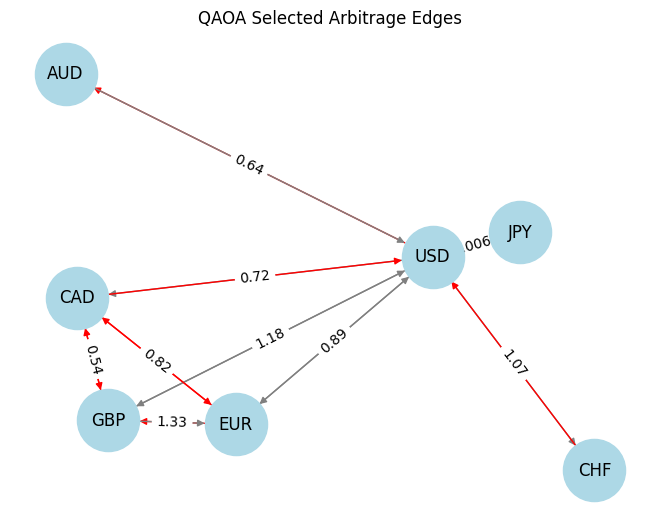

In [26]:
edge_colors = ["red" if edge in selected_edges else "gray" for edge in edges]
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, edge_color=edge_colors)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("QAOA Selected Arbitrage Edges")
plt.show()